In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense



# Simulation 1 : Parameters are generated uniformly 

In [10]:
# Black-Scholes formula for European call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Generate synthetic Black-Scholes option prices
def generate_data(n_samples):
    S = np.random.uniform(50, 150, n_samples)  # Stock price
    K = 100  # Strike price
    T = np.random.uniform(0.02, 2, n_samples)  # Time to maturity
    r = np.random.uniform(0.01, 0.1, n_samples)  # Risk-free rate
    sigma = np.random.uniform(0.1, 0.5, n_samples)  # Volatility
    prices = black_scholes_call(S, K, T, r, sigma)
    
    data = pd.DataFrame({'S': S, 'K': K, 'T': T, 'r': r, 'sigma': sigma, 'C': prices})

    return data


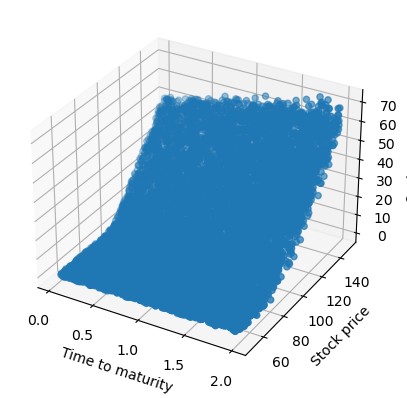

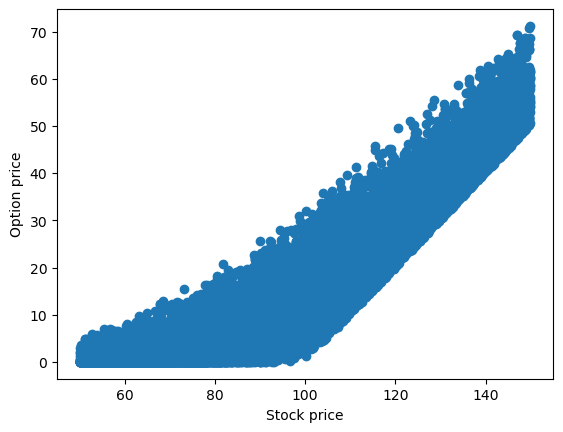

In [15]:

np.random.seed(42)

# Generate synthetic data
n_samples = 10000

data = generate_data(n_samples)

# Split data into training and test sets
X = data[['S', 'K', 'T', 'r', 'sigma']]
y = data['C']


# plot option prices in a 3D plot as a function of time to maturity and stock price
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['T'], X['S'], y)
ax.set_xlabel('Time to maturity')
ax.set_ylabel('Stock price')
ax.set_zlabel('Option price')
plt.show()

# plot option prices in a 2D plot as a function of stock price
plt.scatter(X['S'], y)
plt.xlabel('Stock price')
plt.ylabel('Option price')
plt.show()



